Trial normalization completed.
Original mean (C3): 255363.20668055557
Normalized mean (C3): -7.905024782909702e-14
Normalized std (C3): 1.0002222963237406


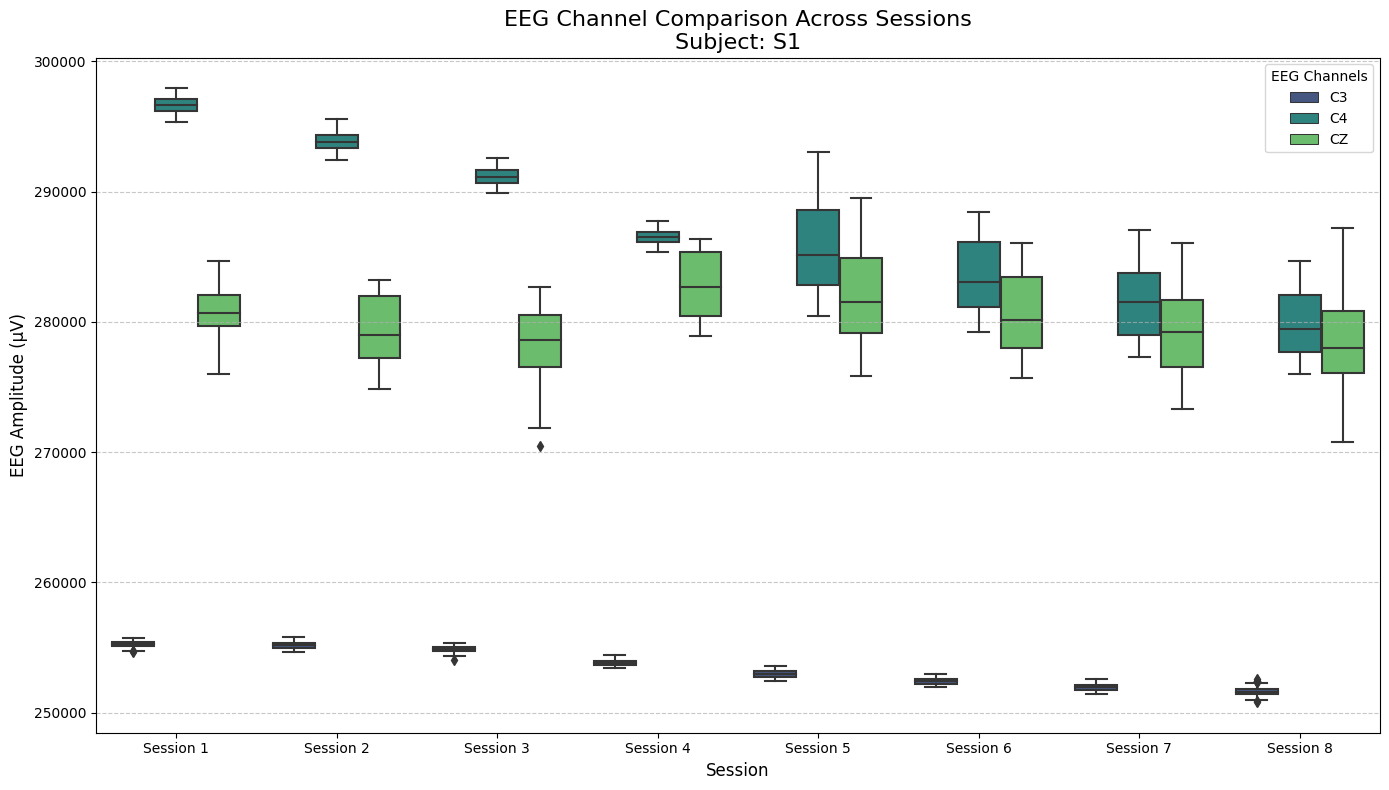

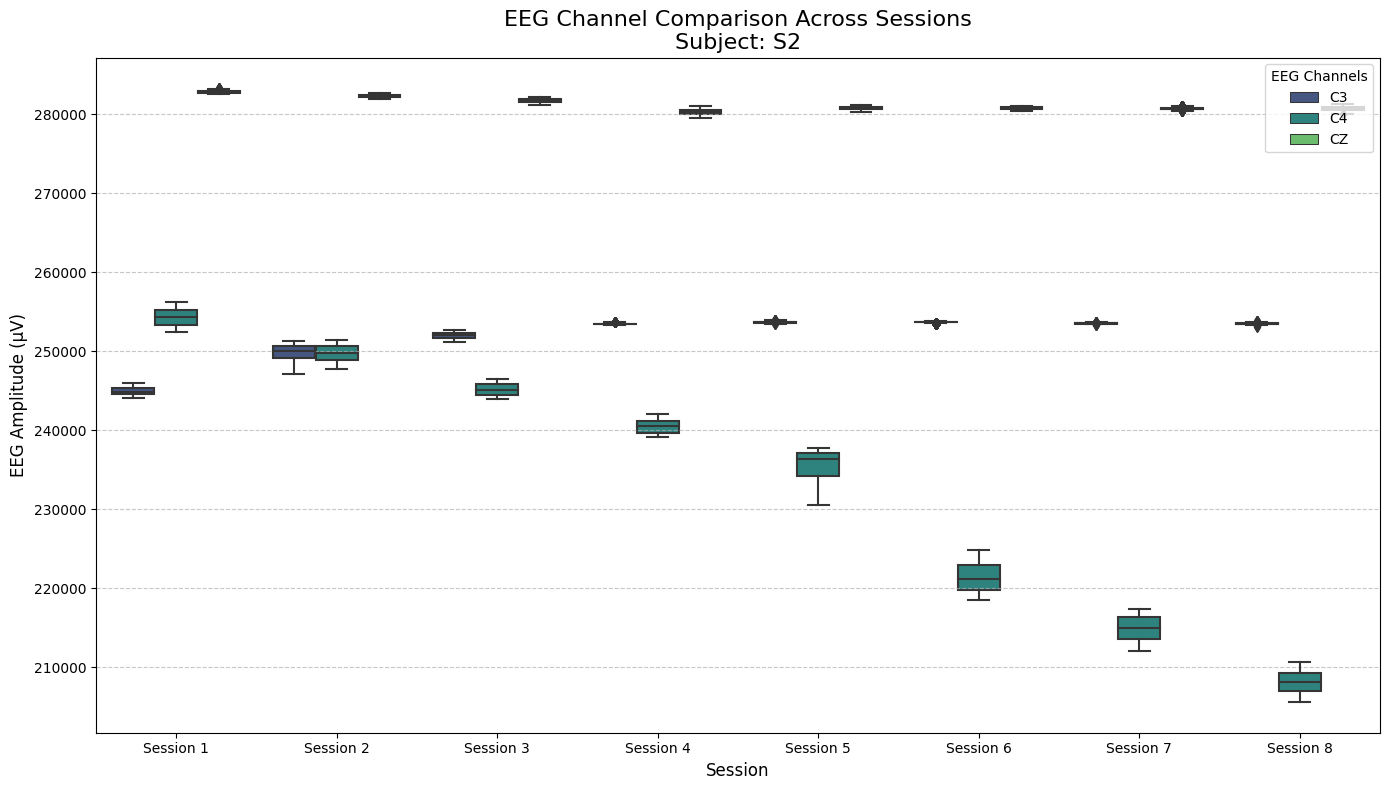

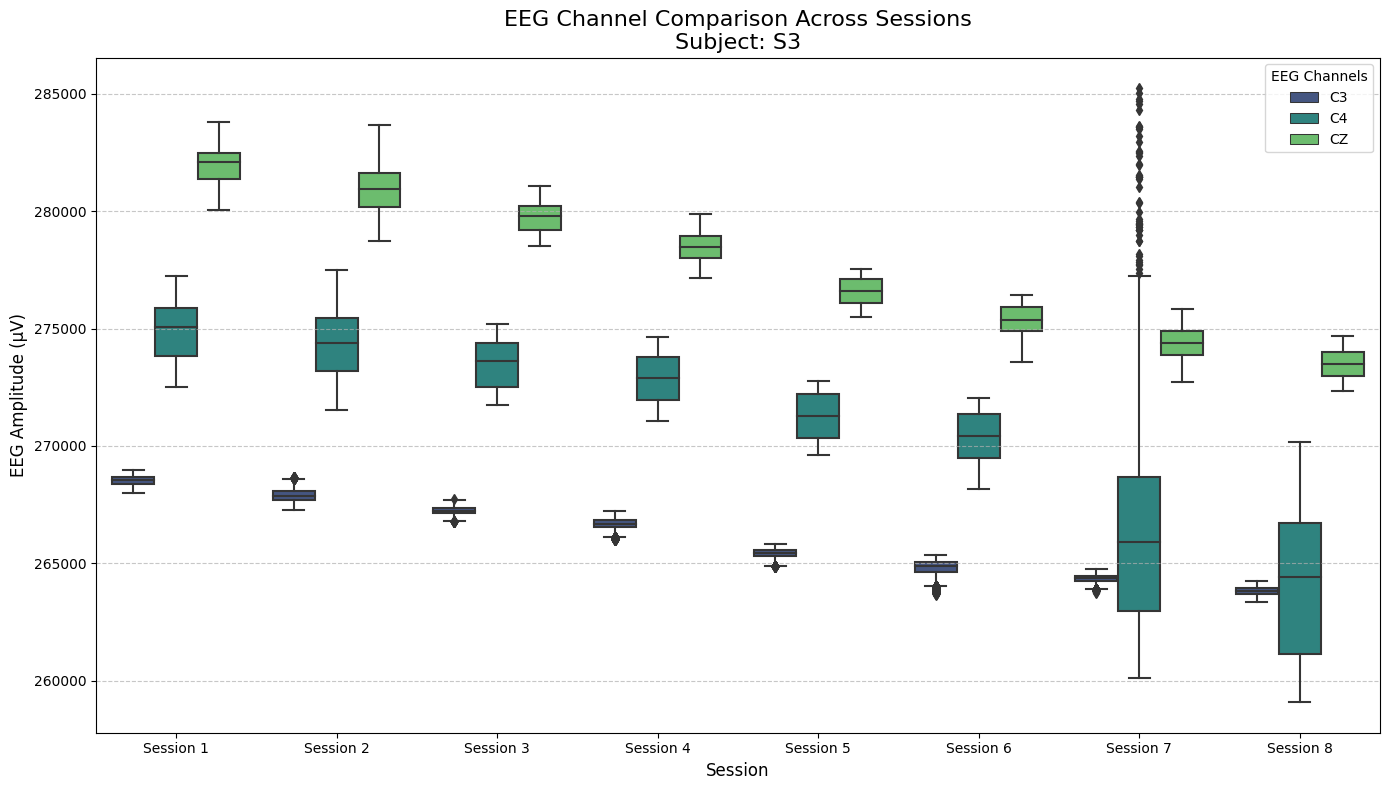

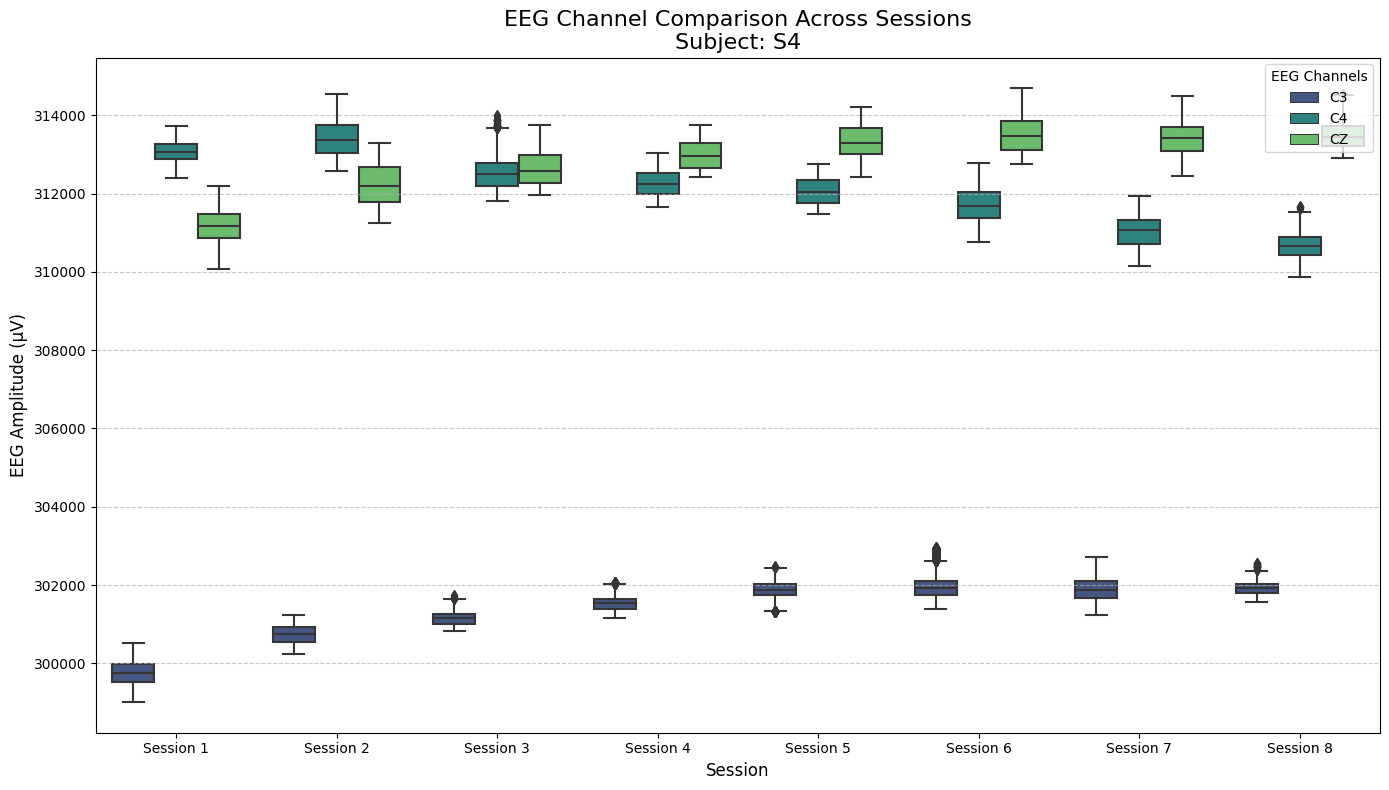

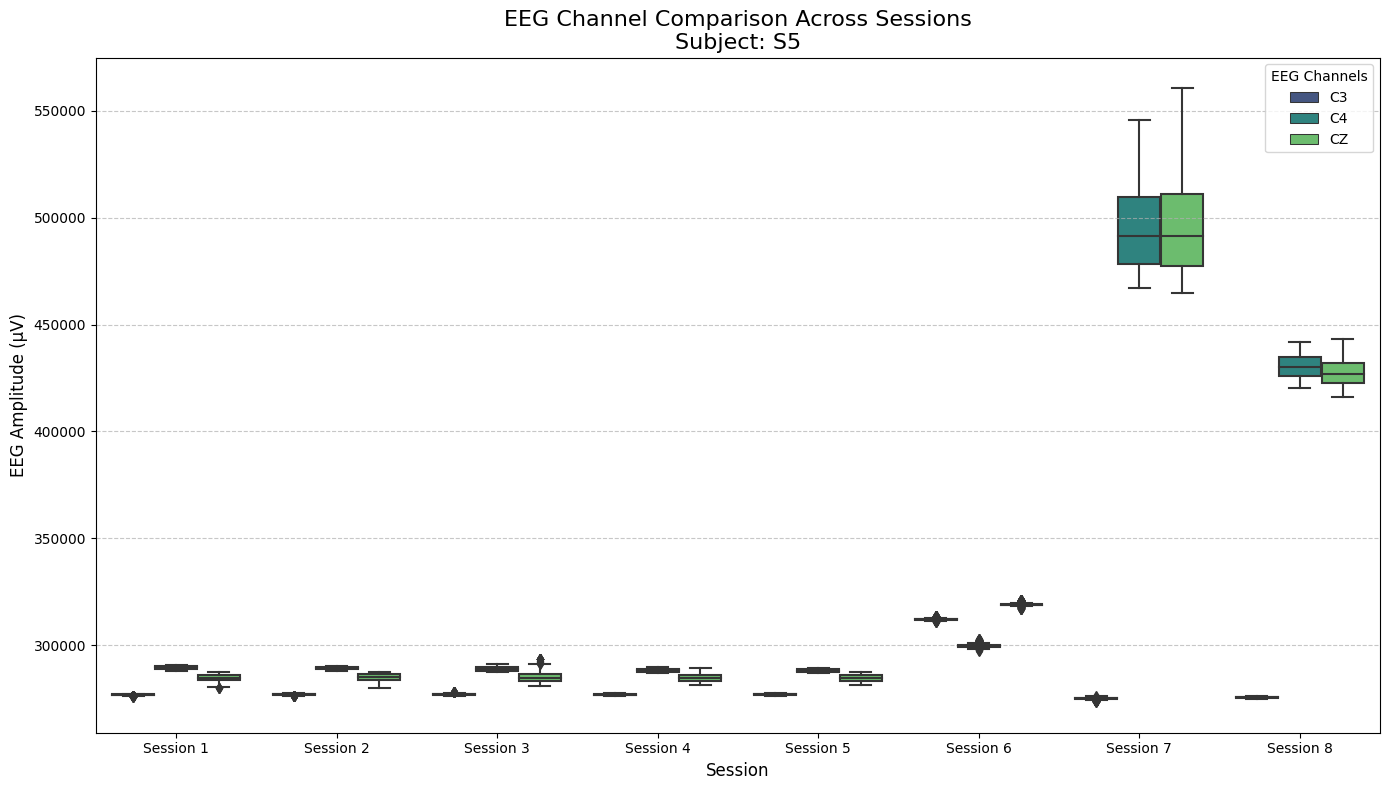

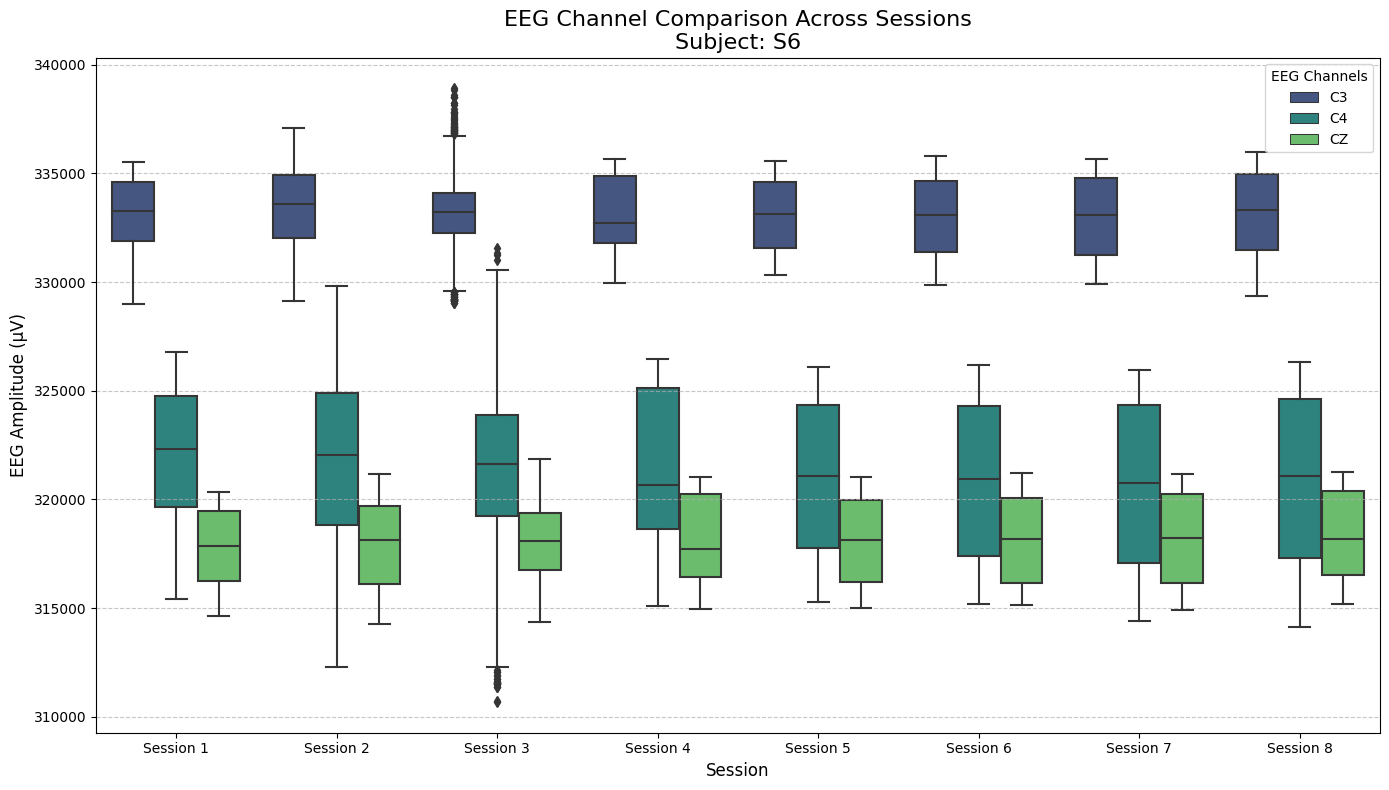

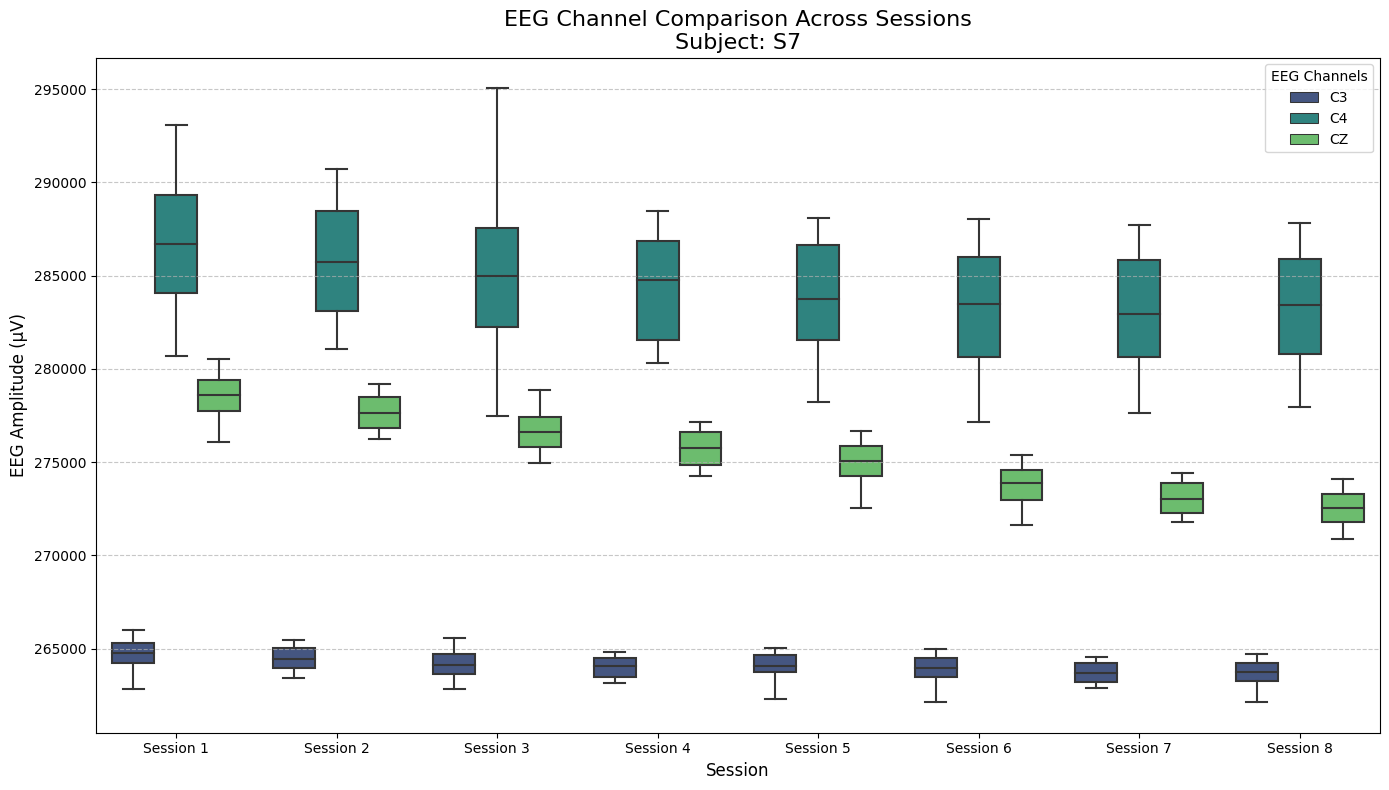

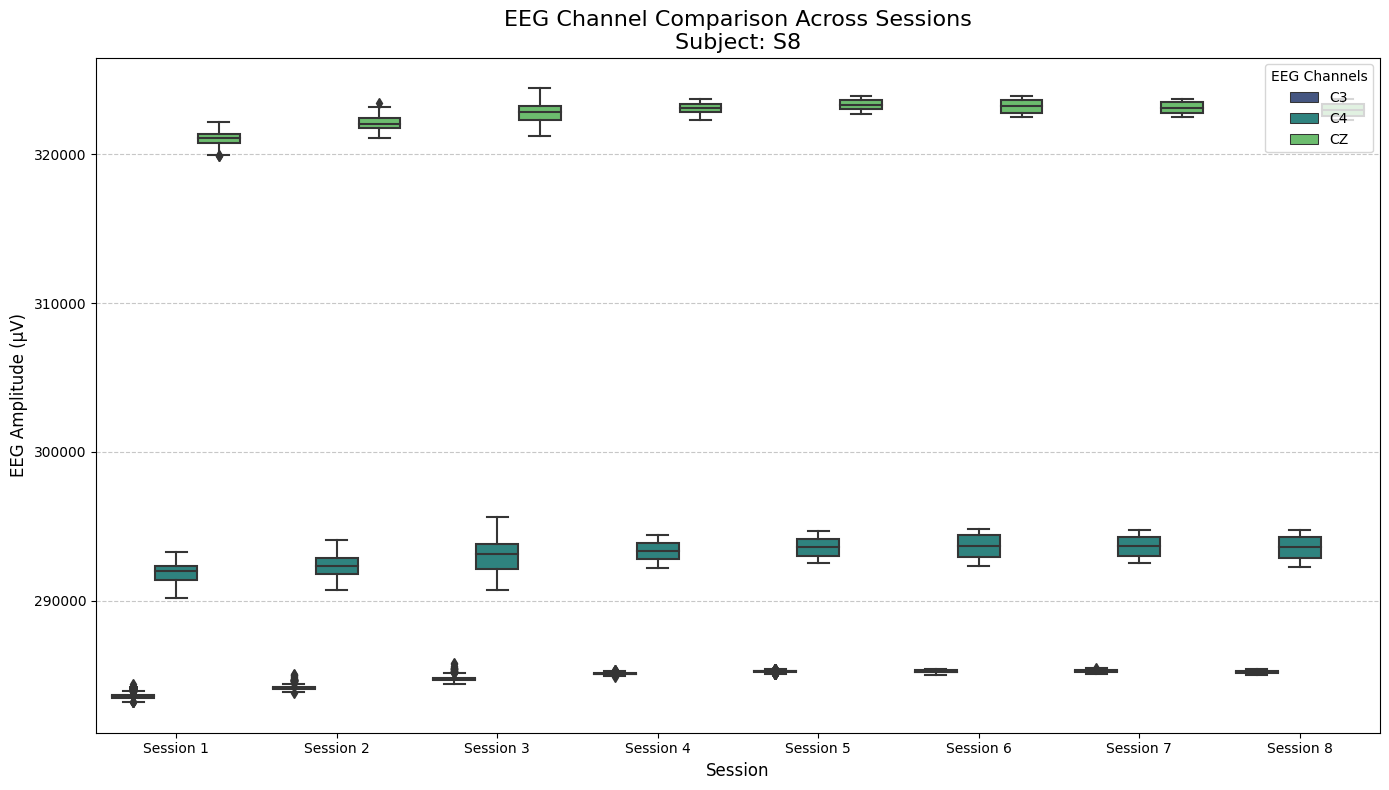

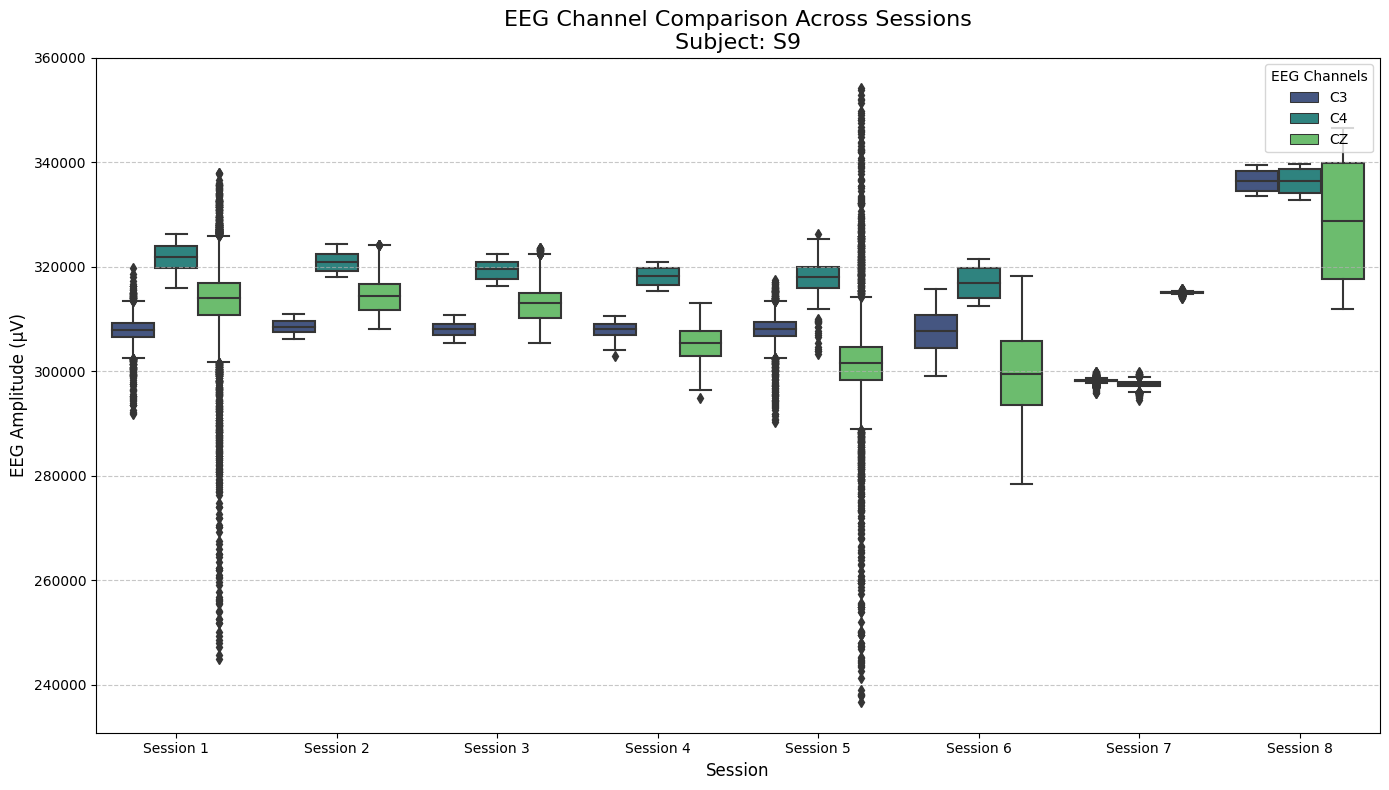

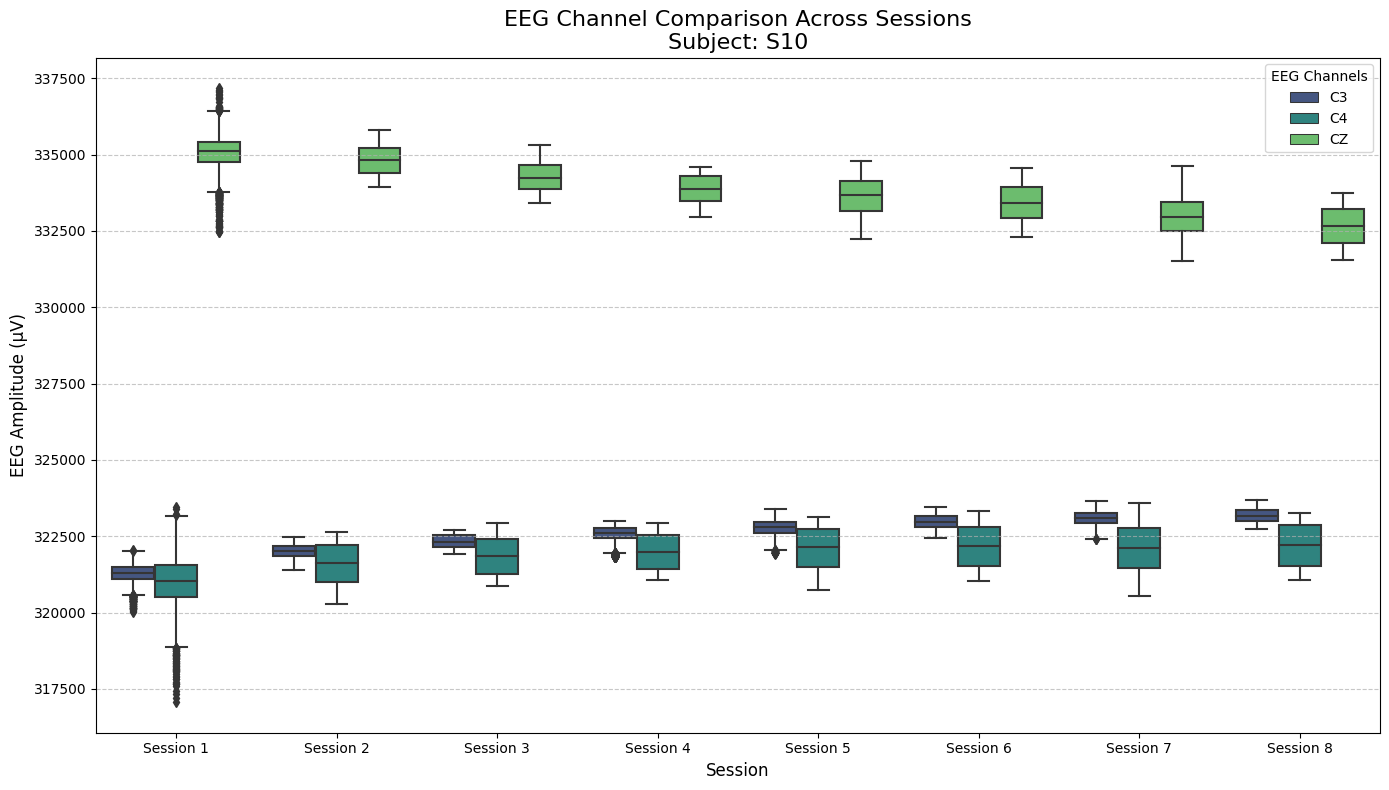

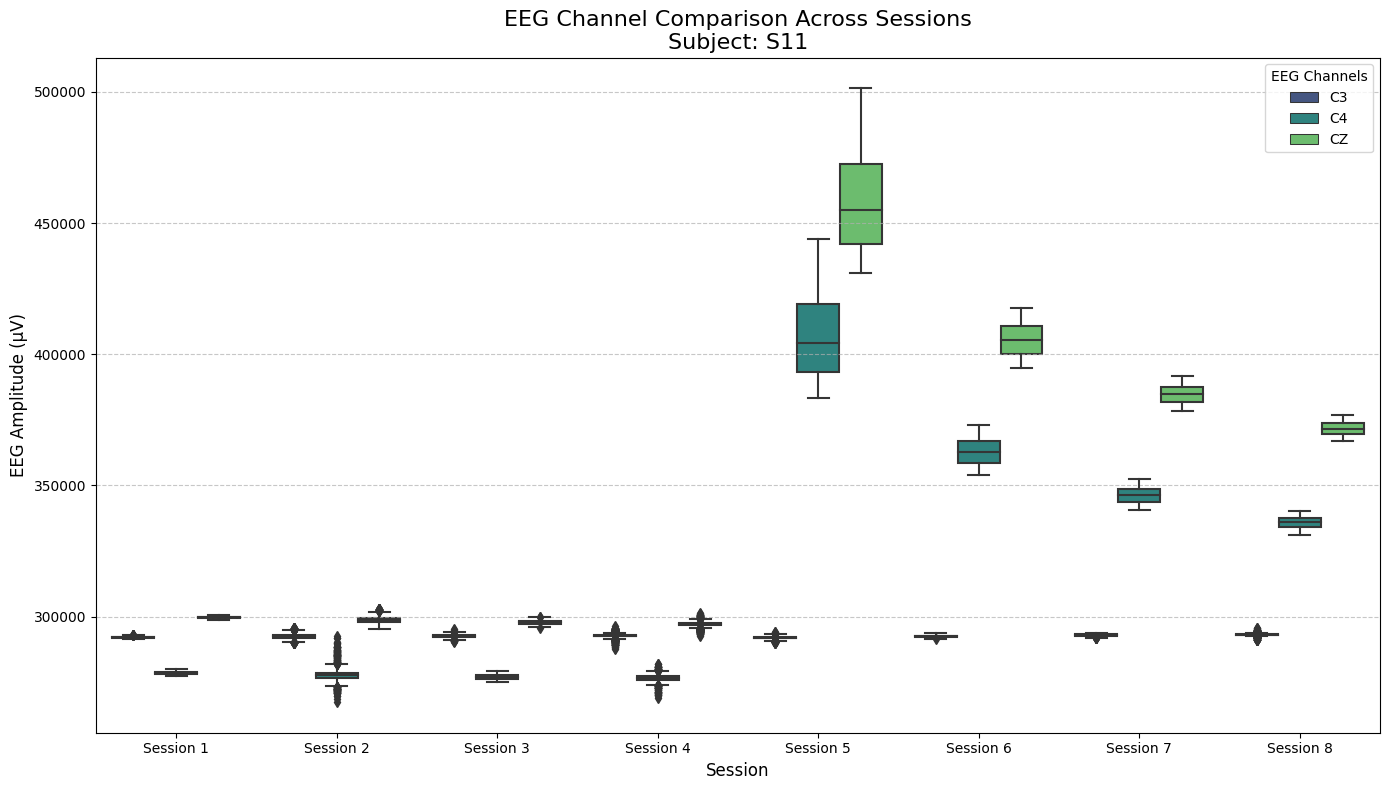

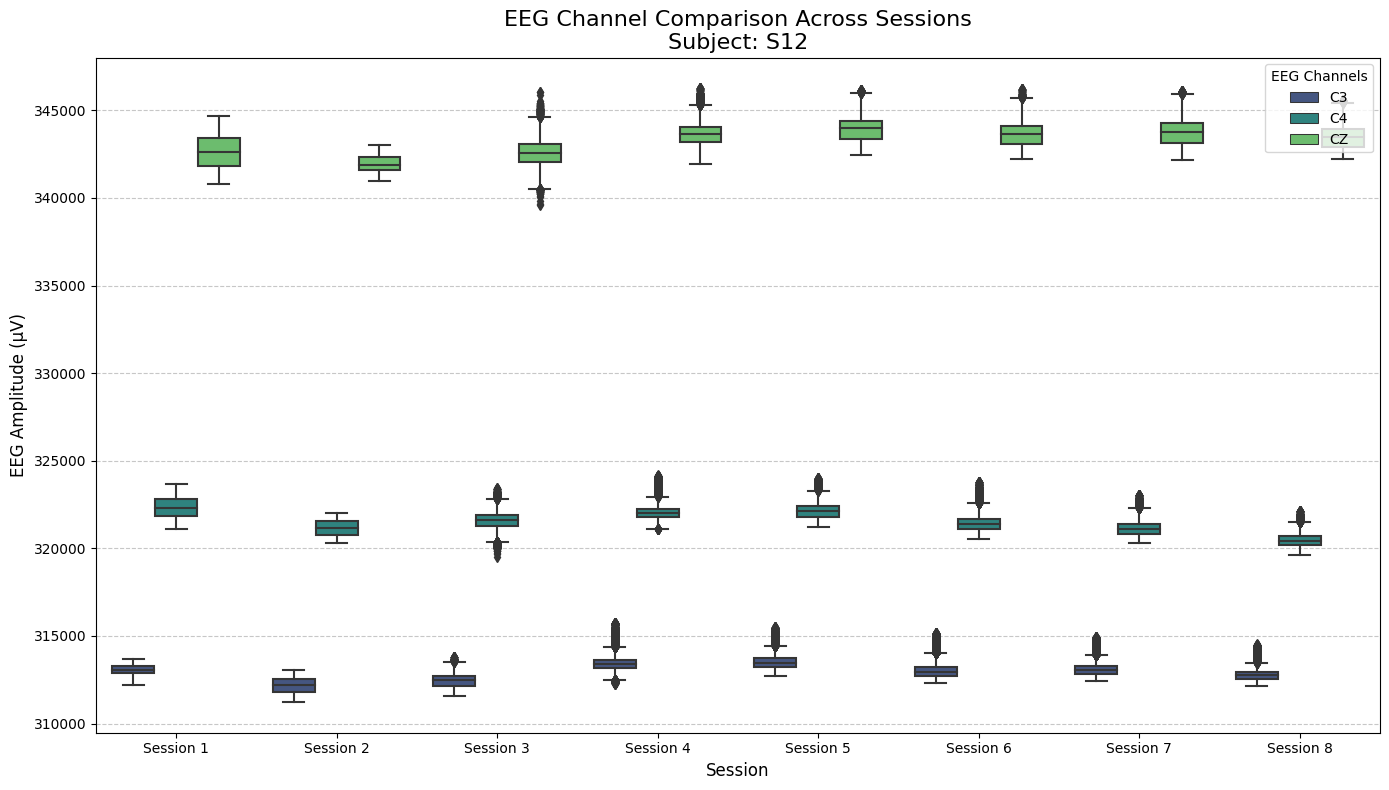

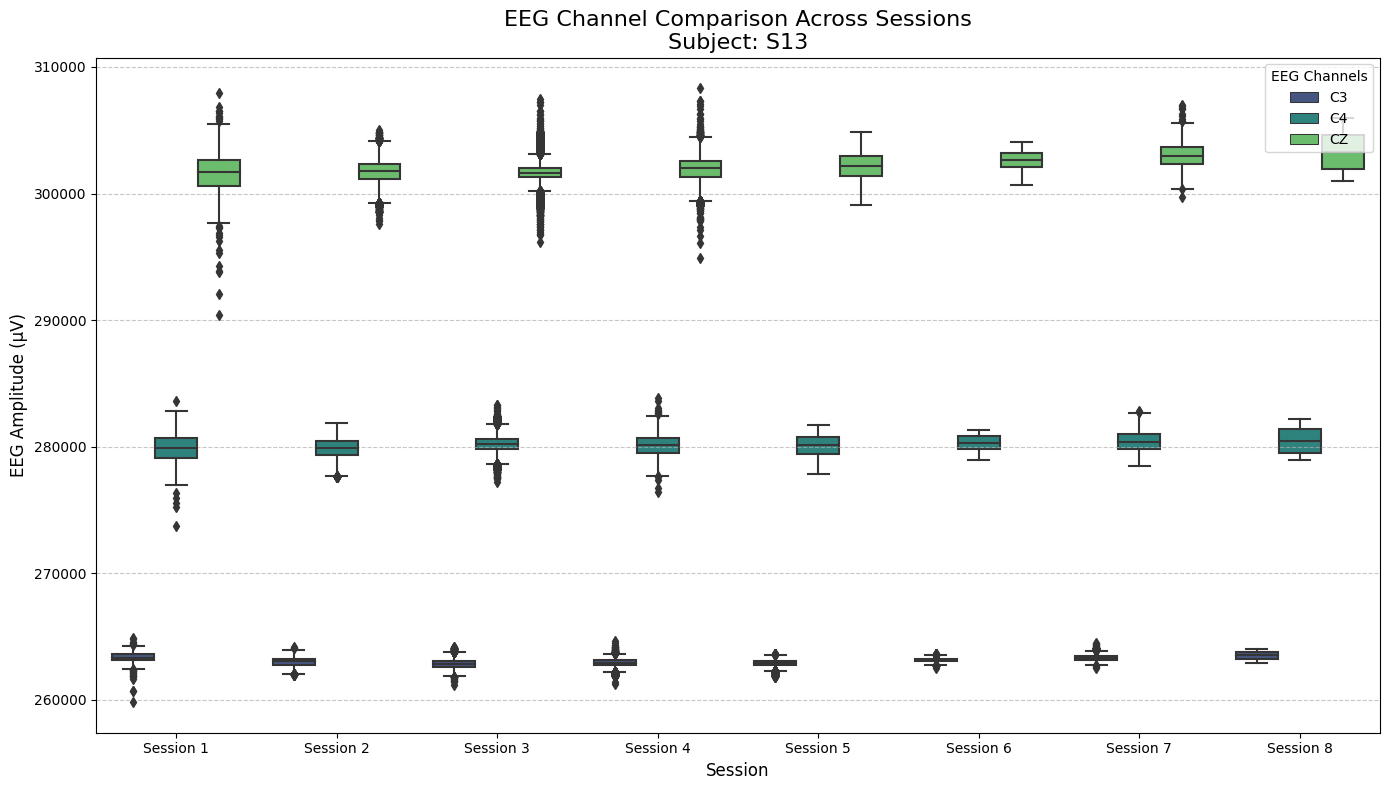

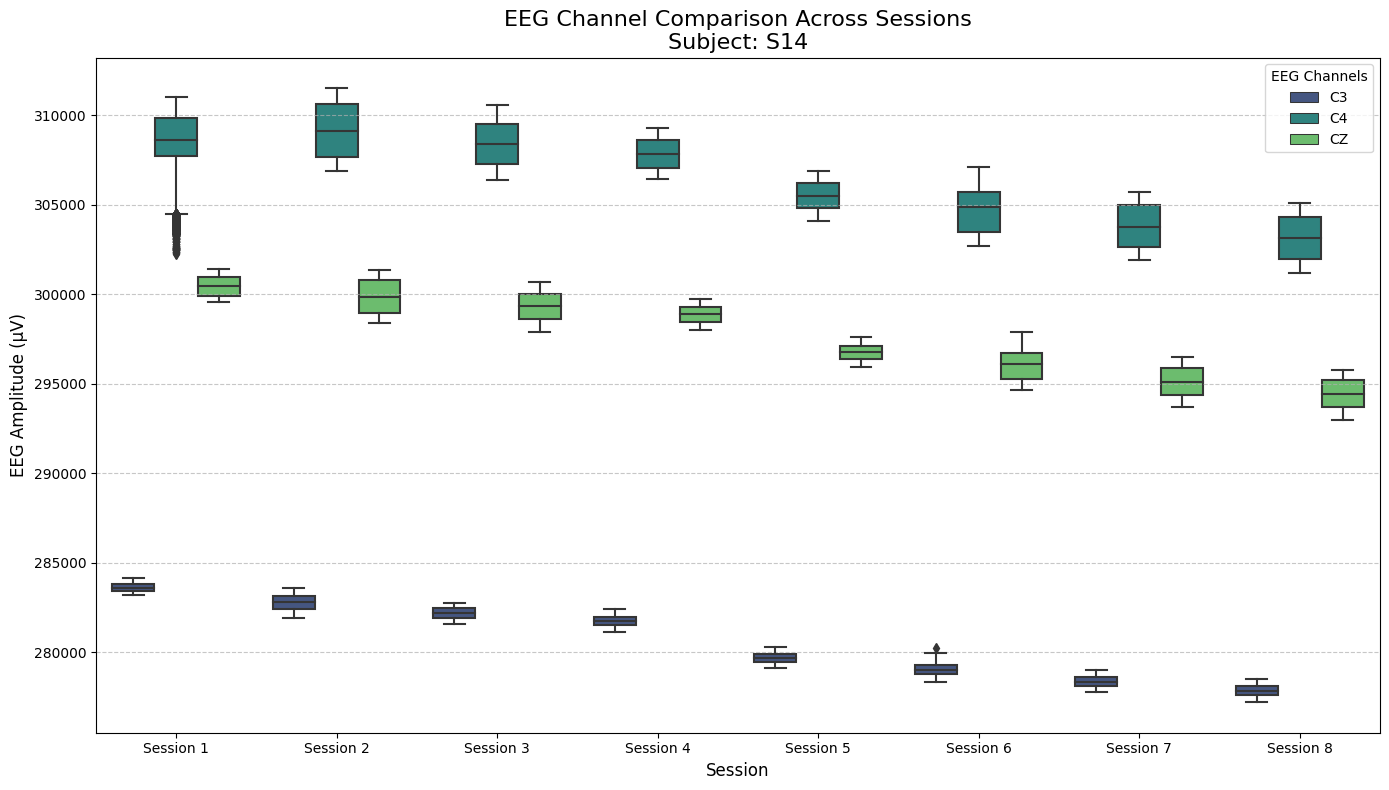

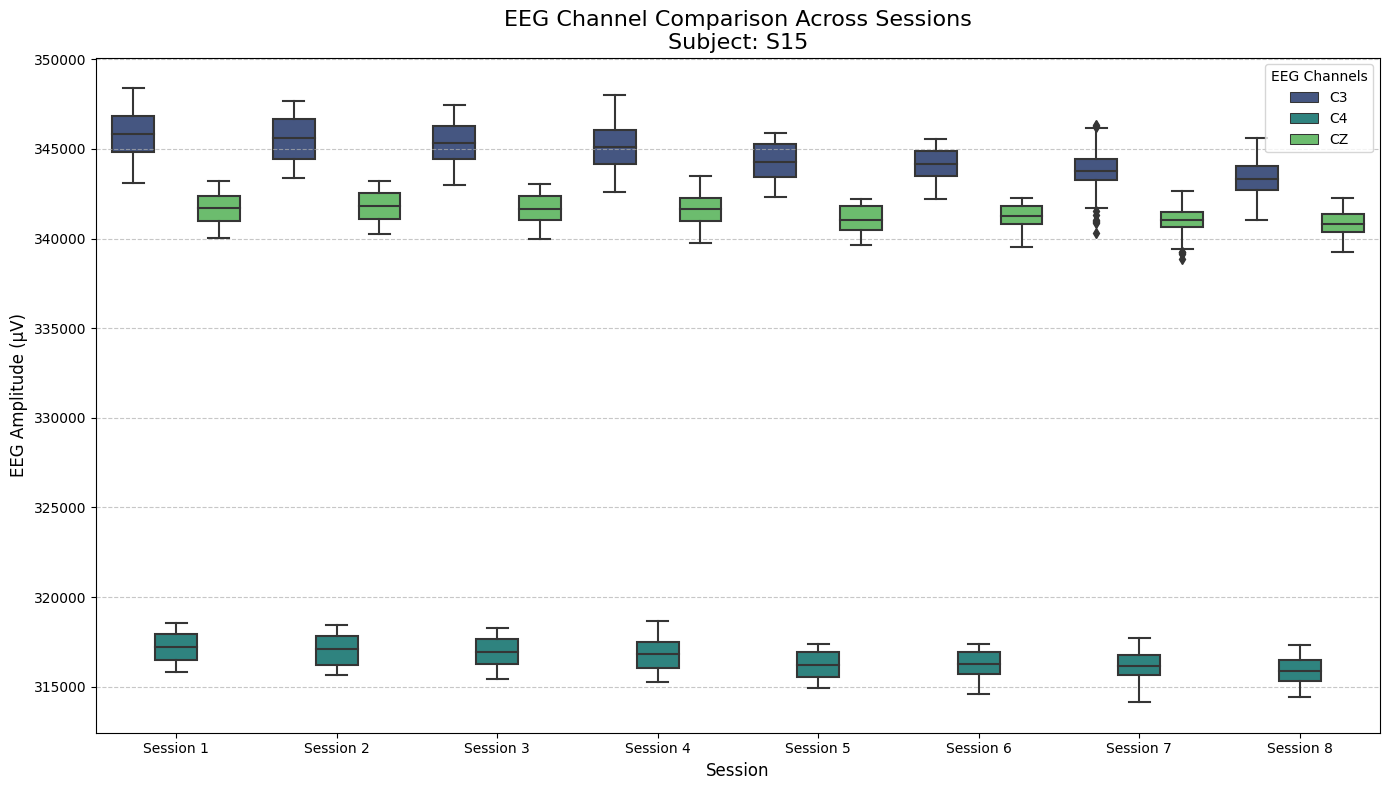

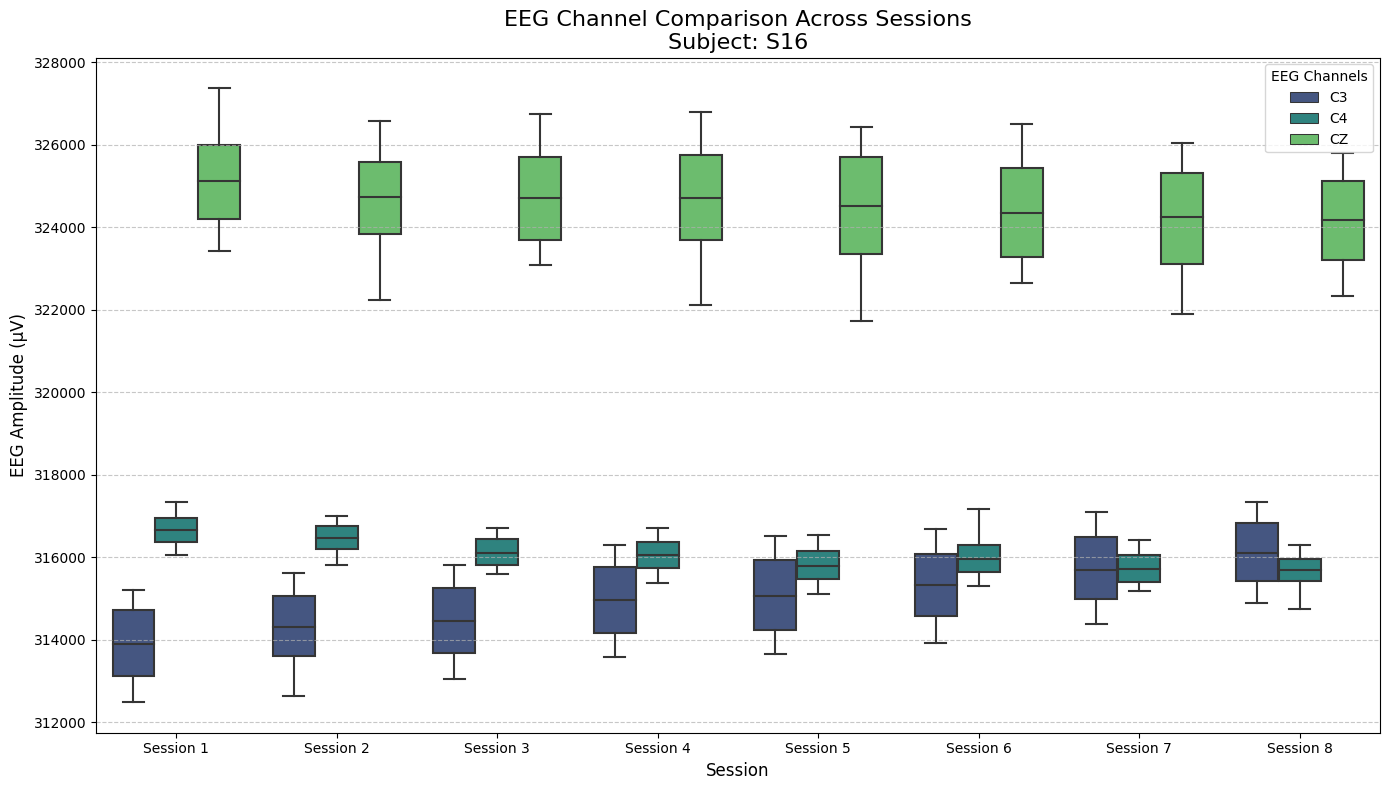

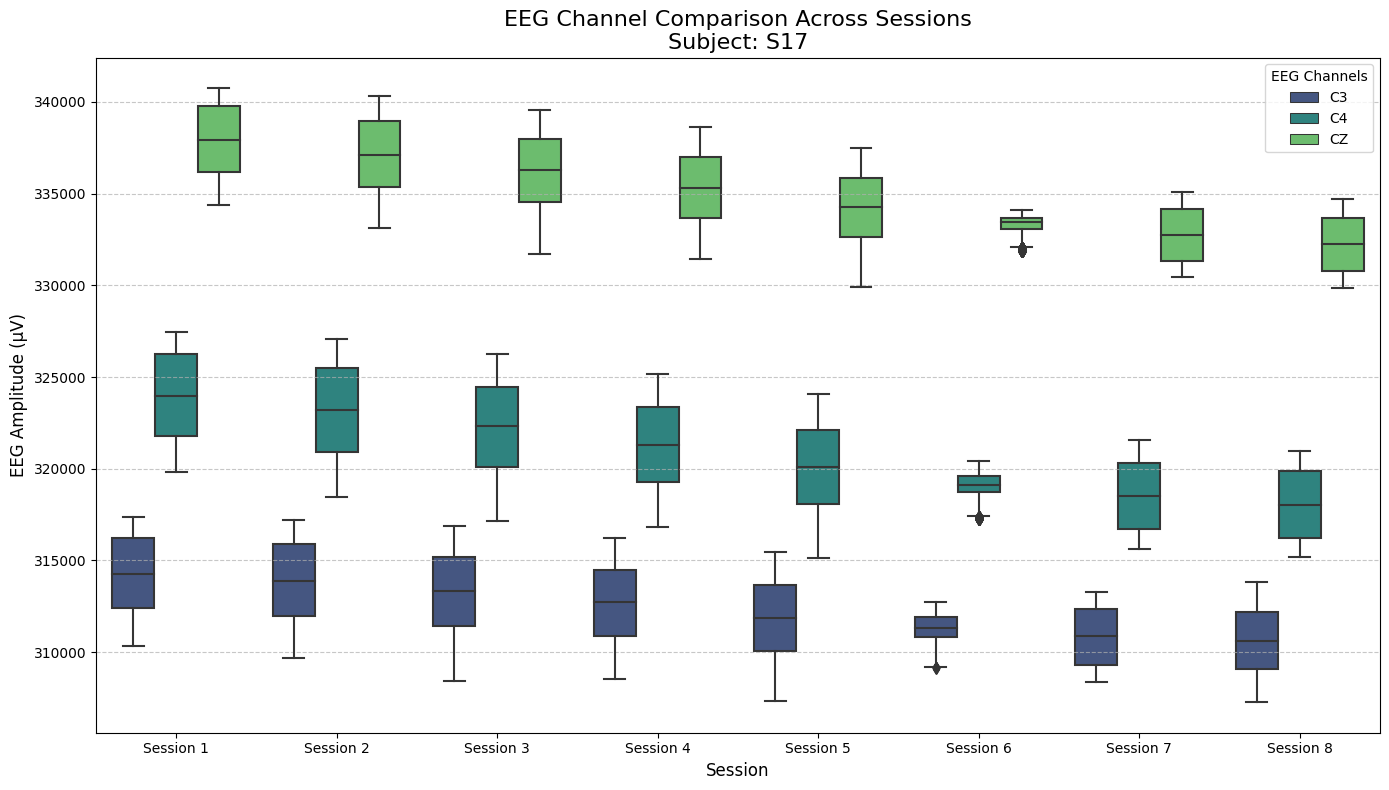

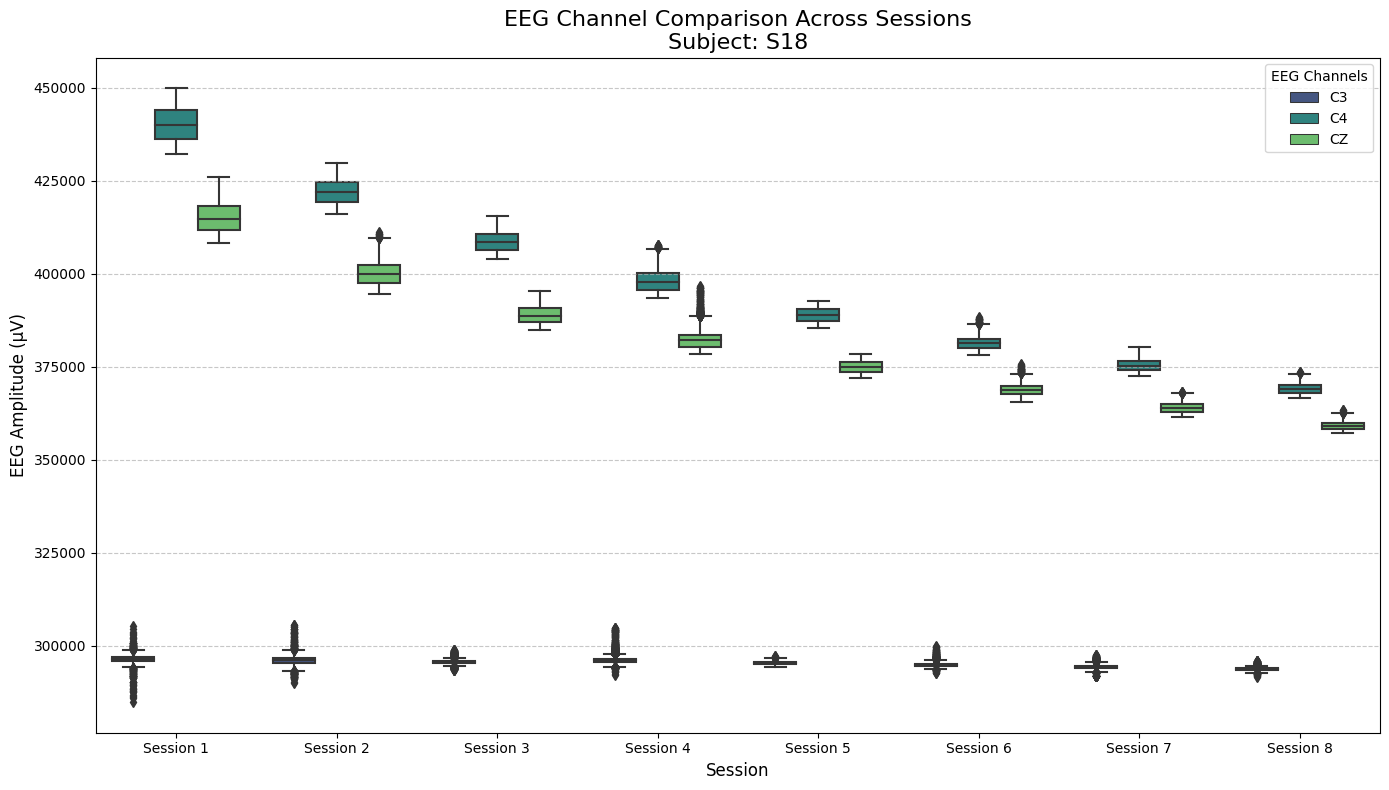

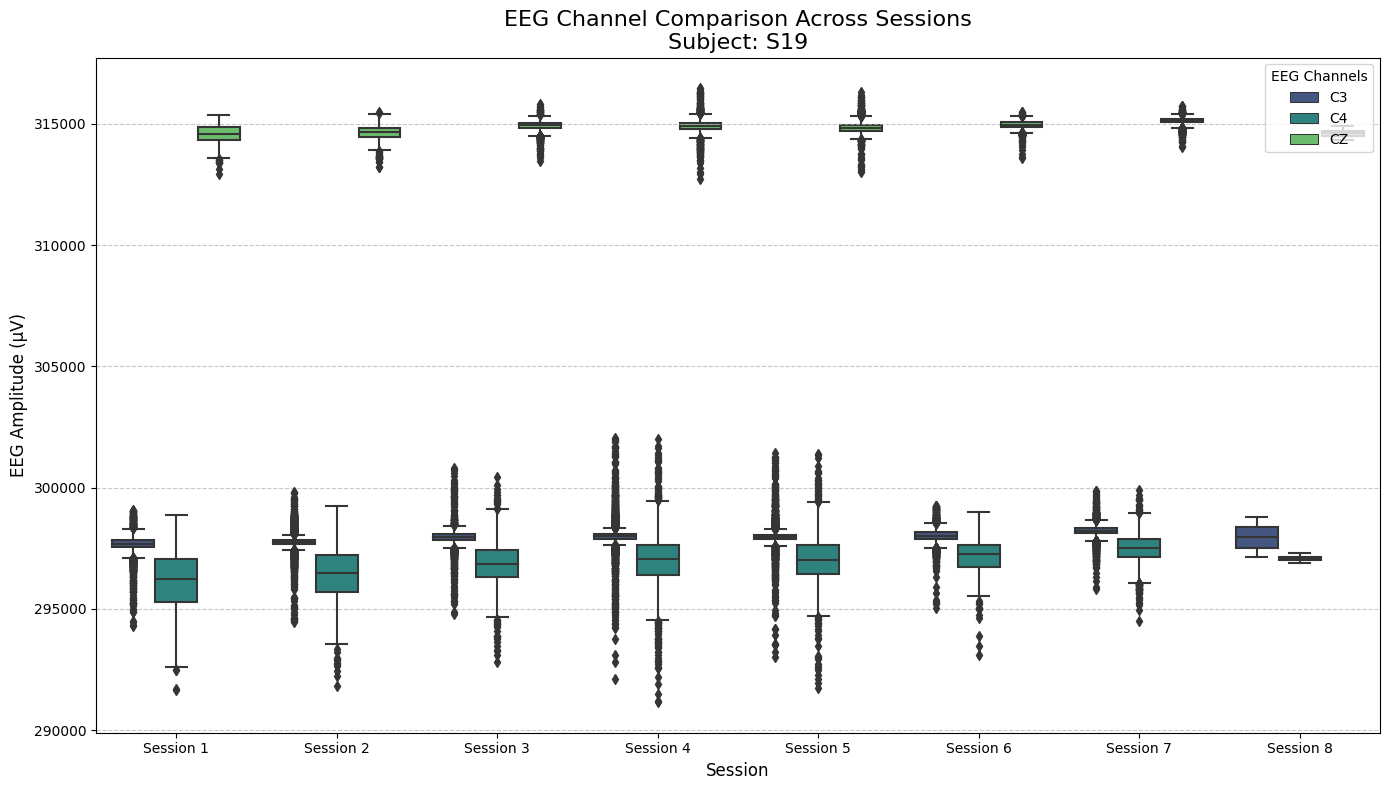

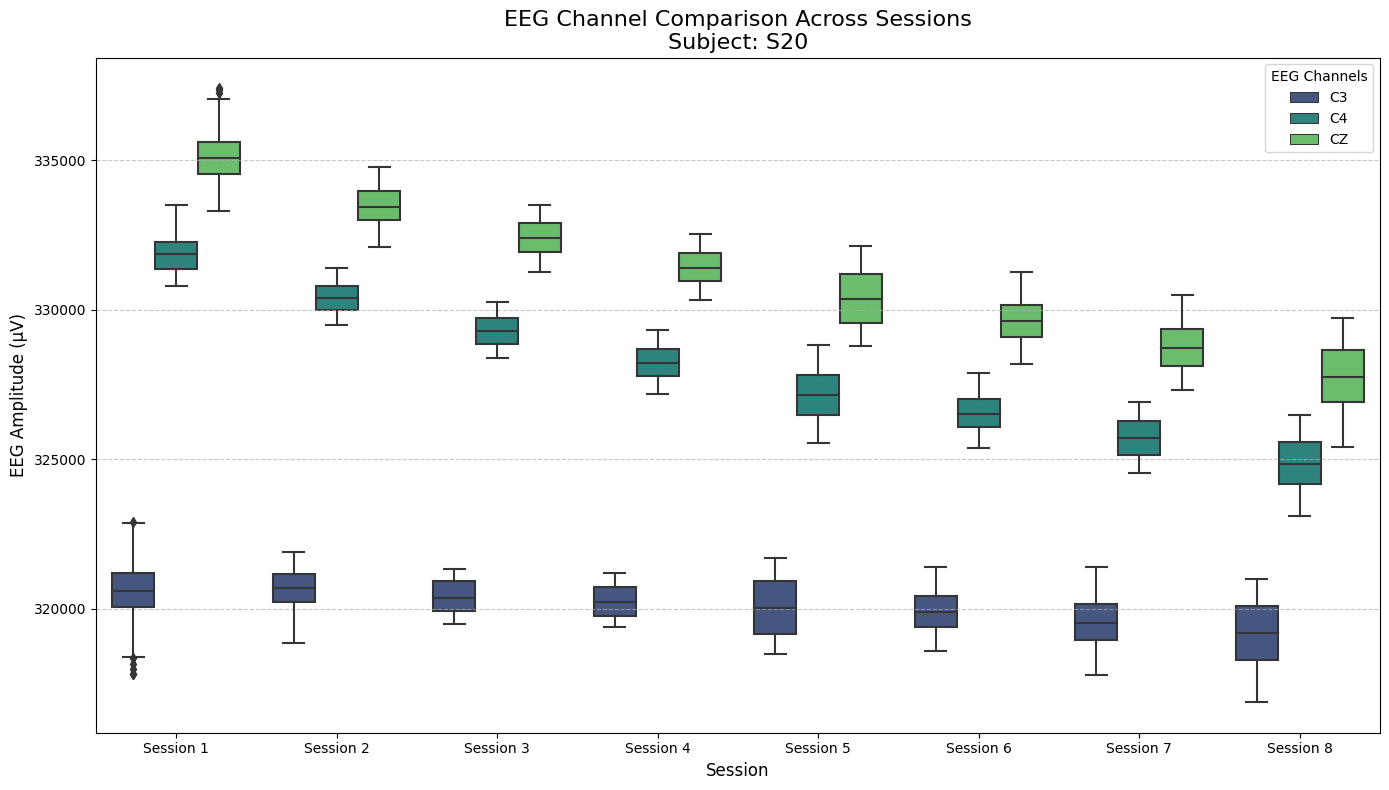

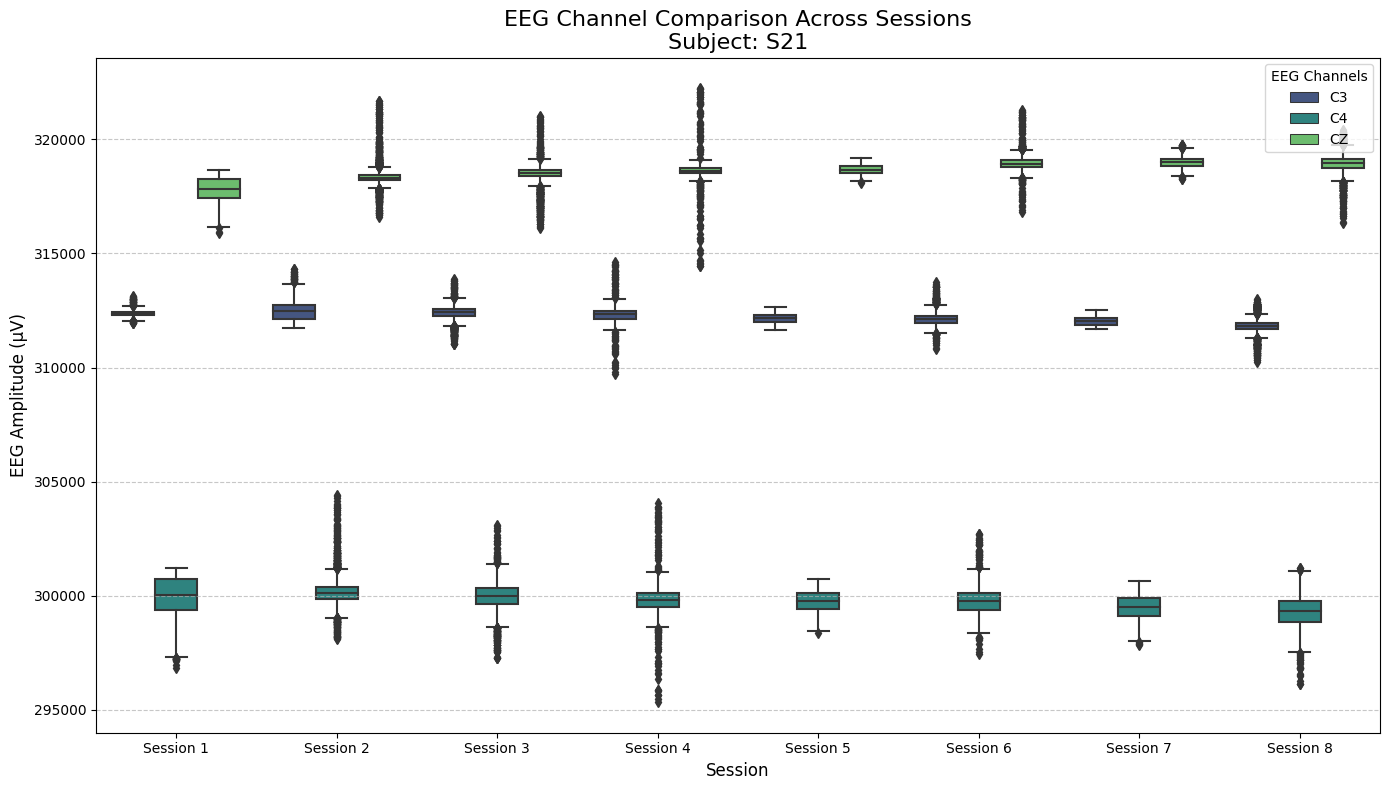

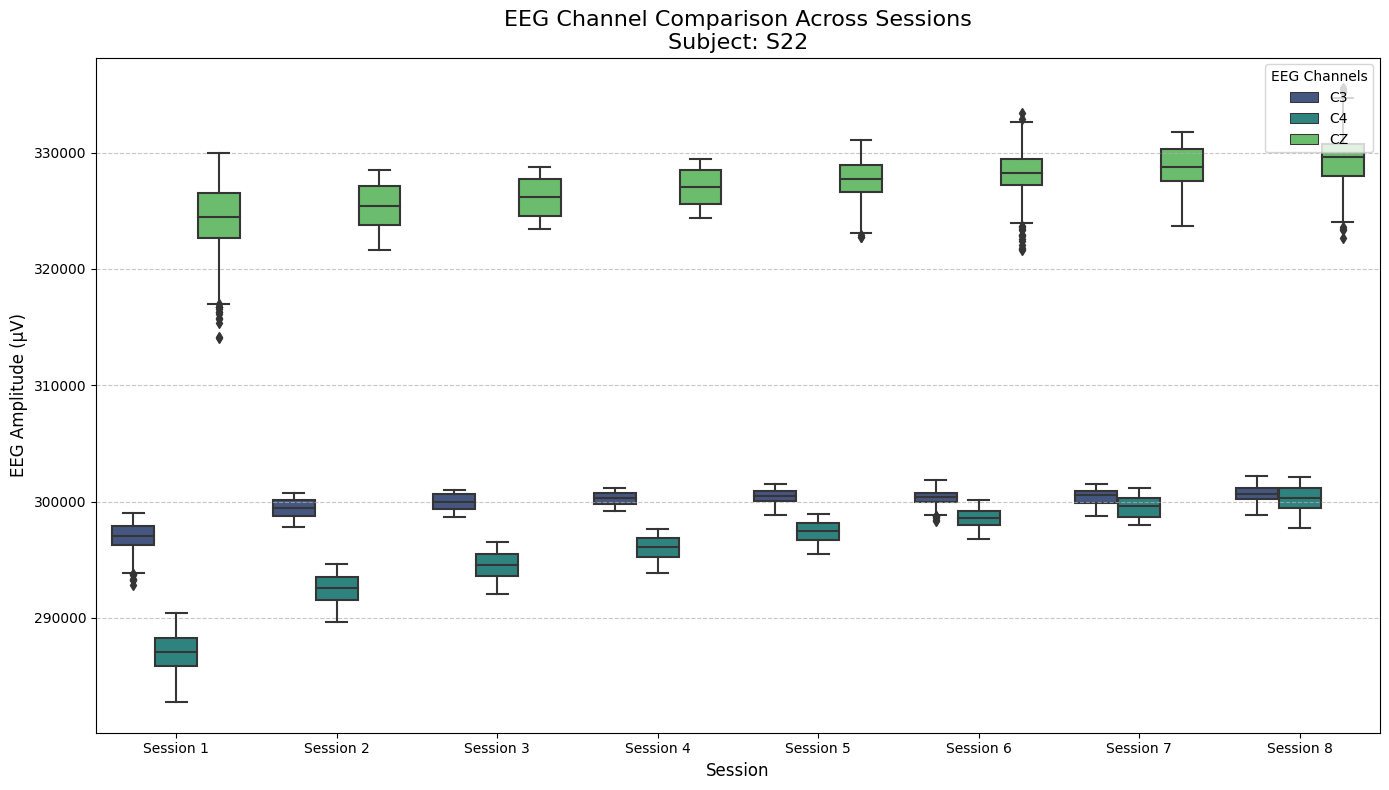

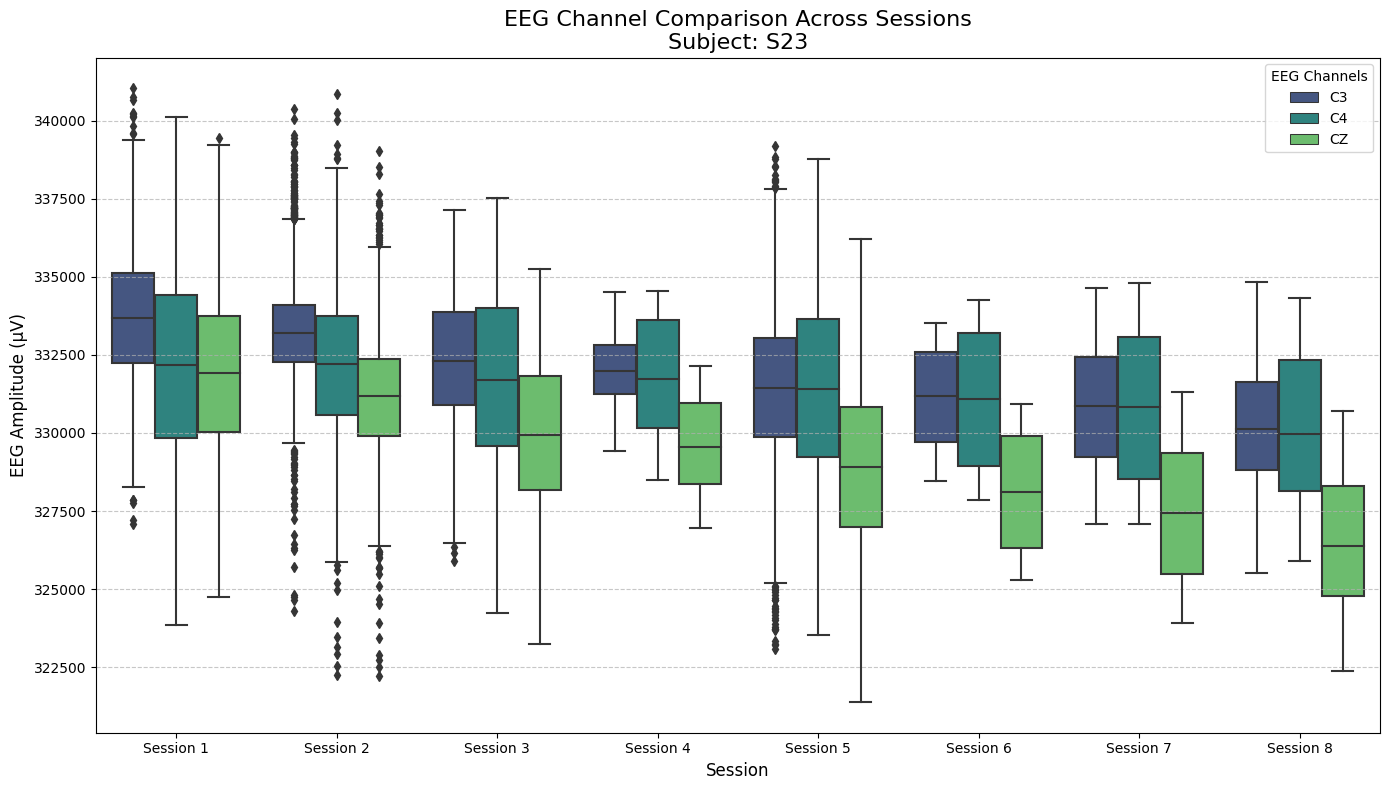

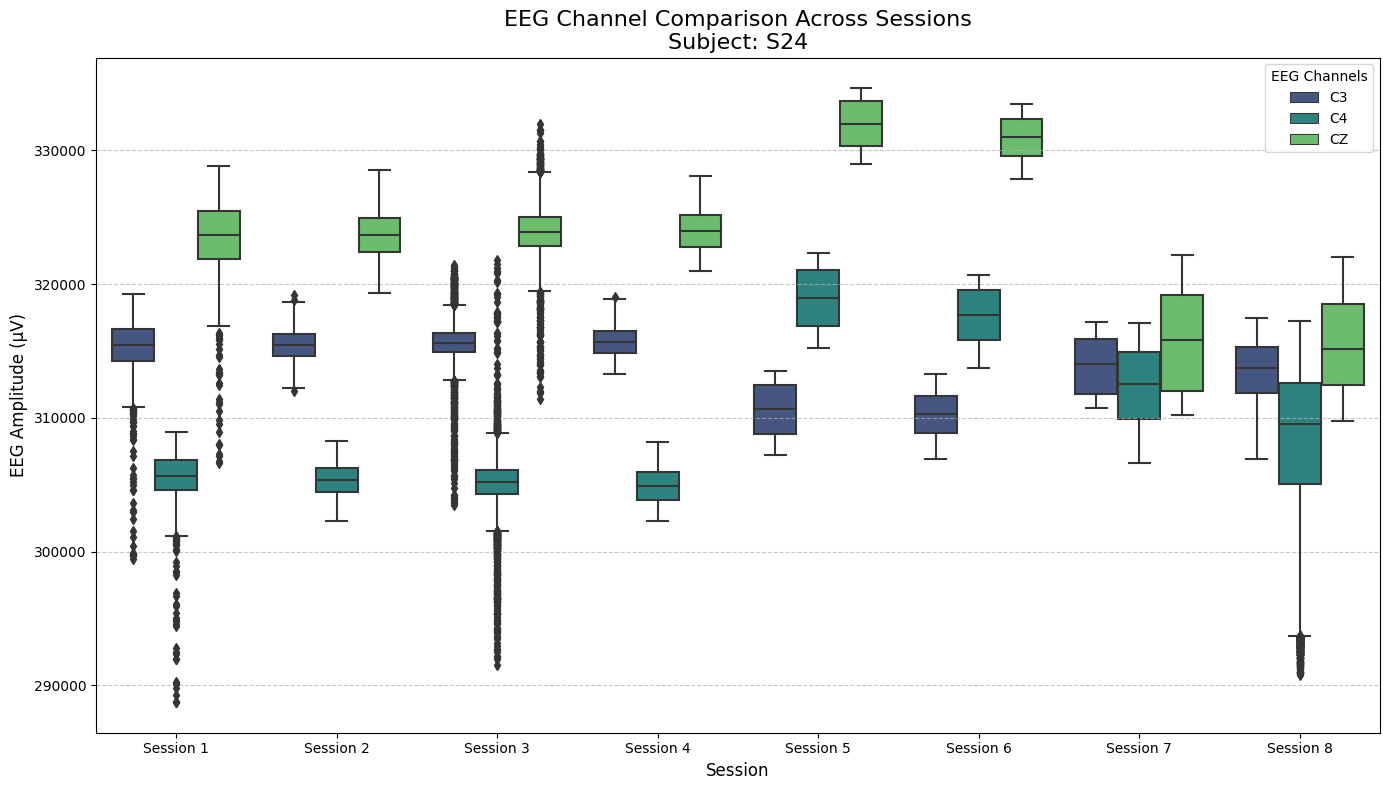

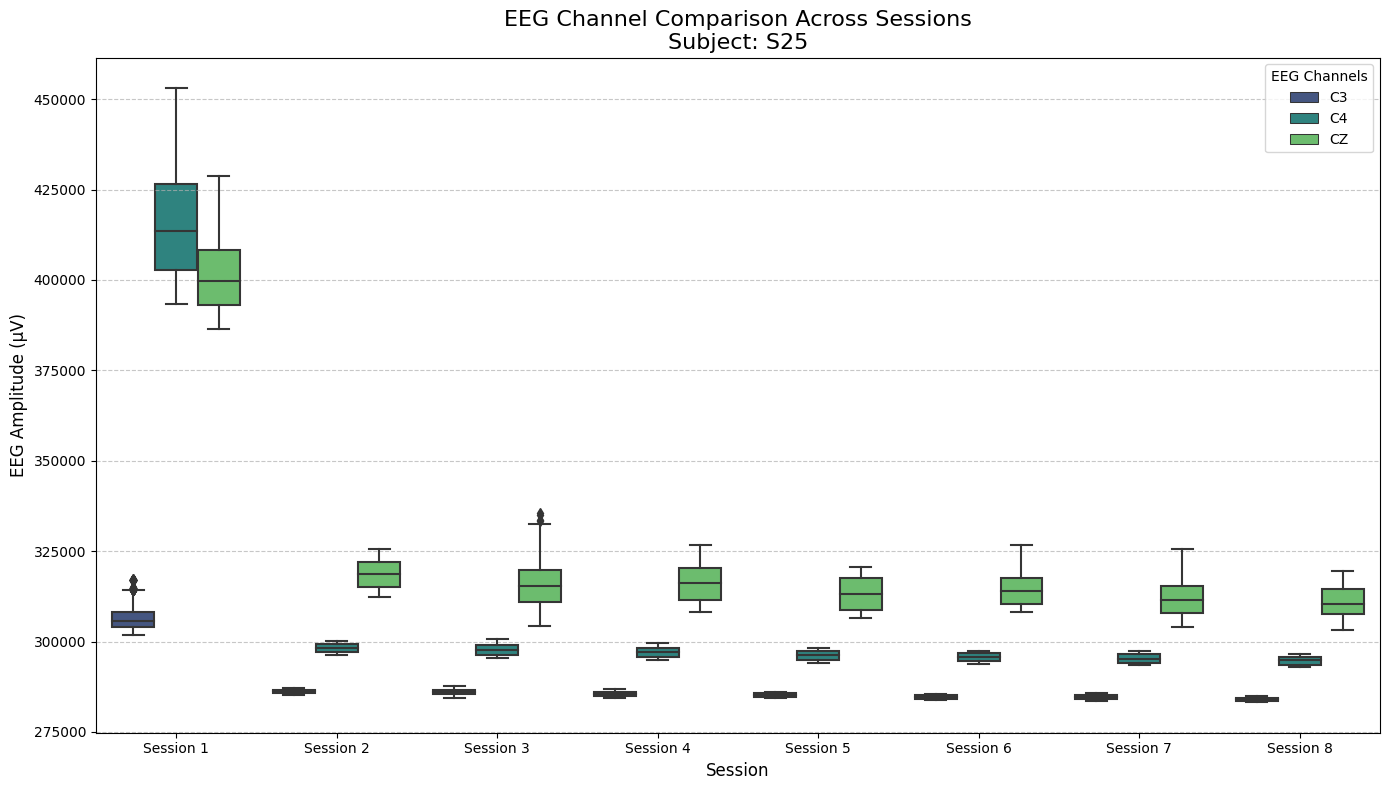

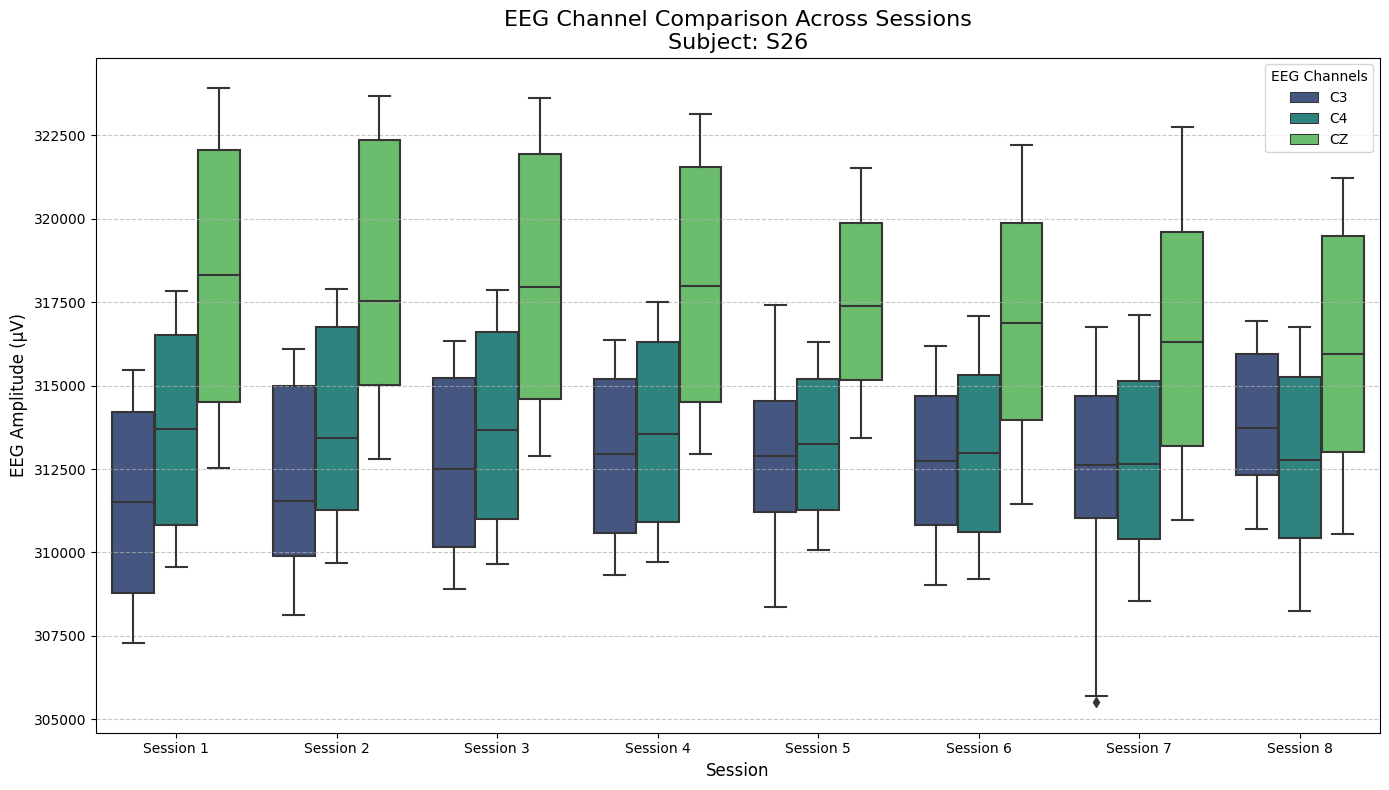

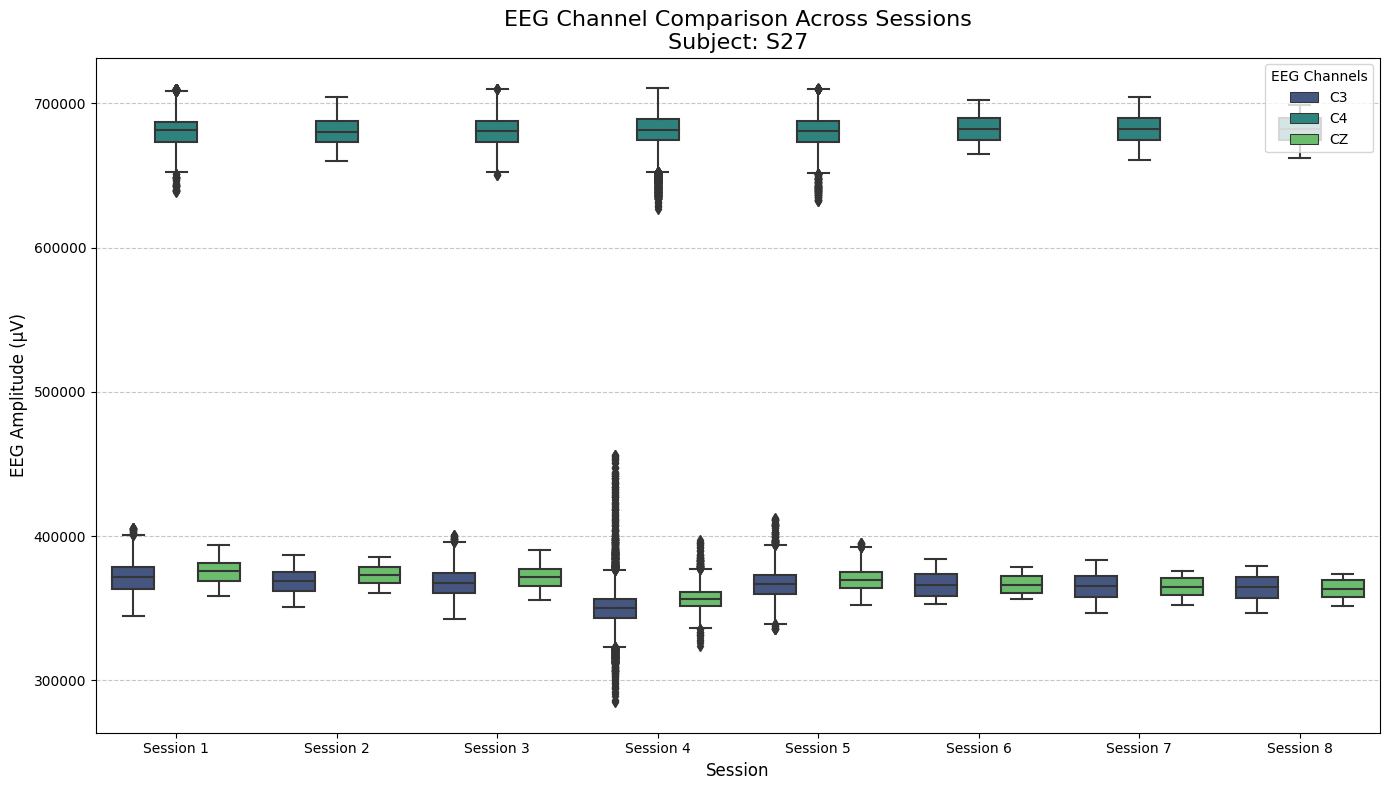

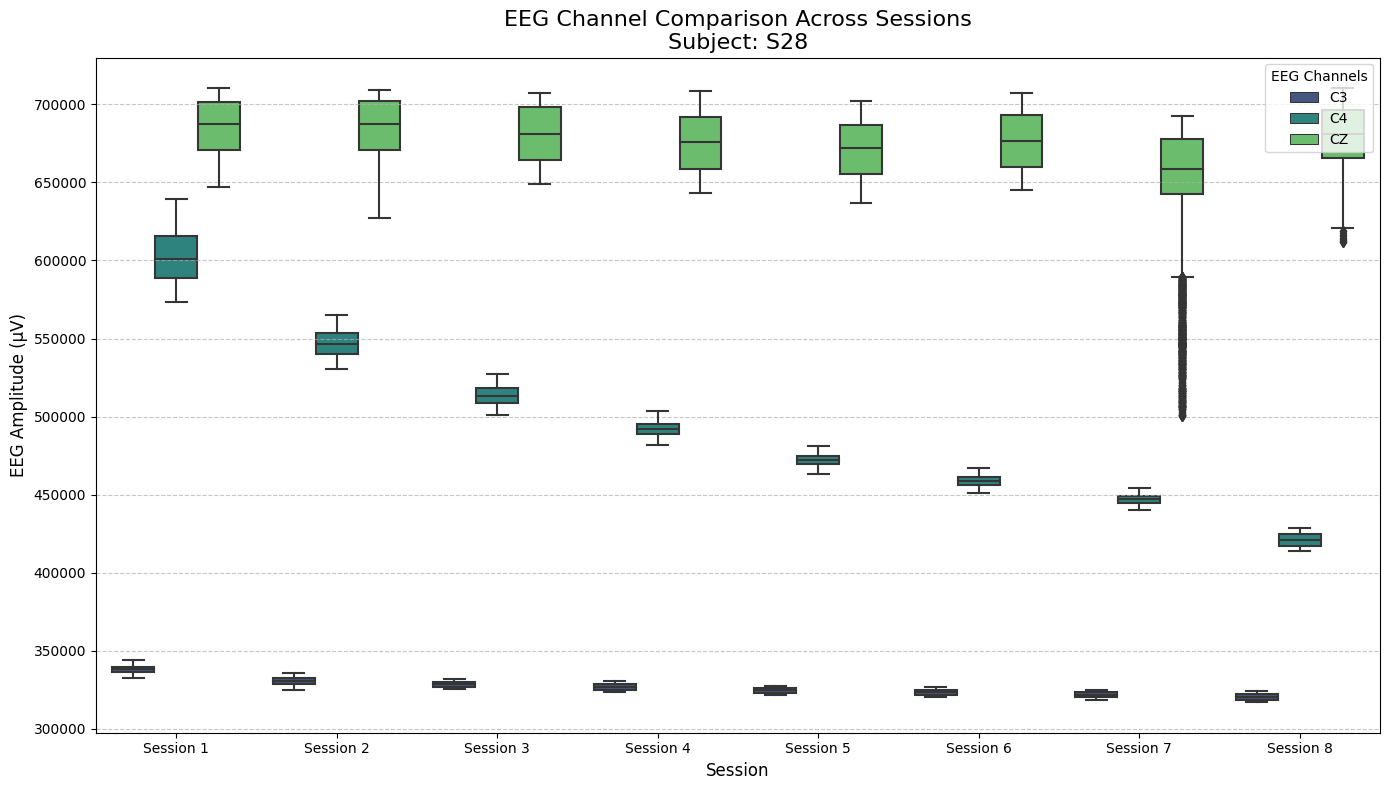

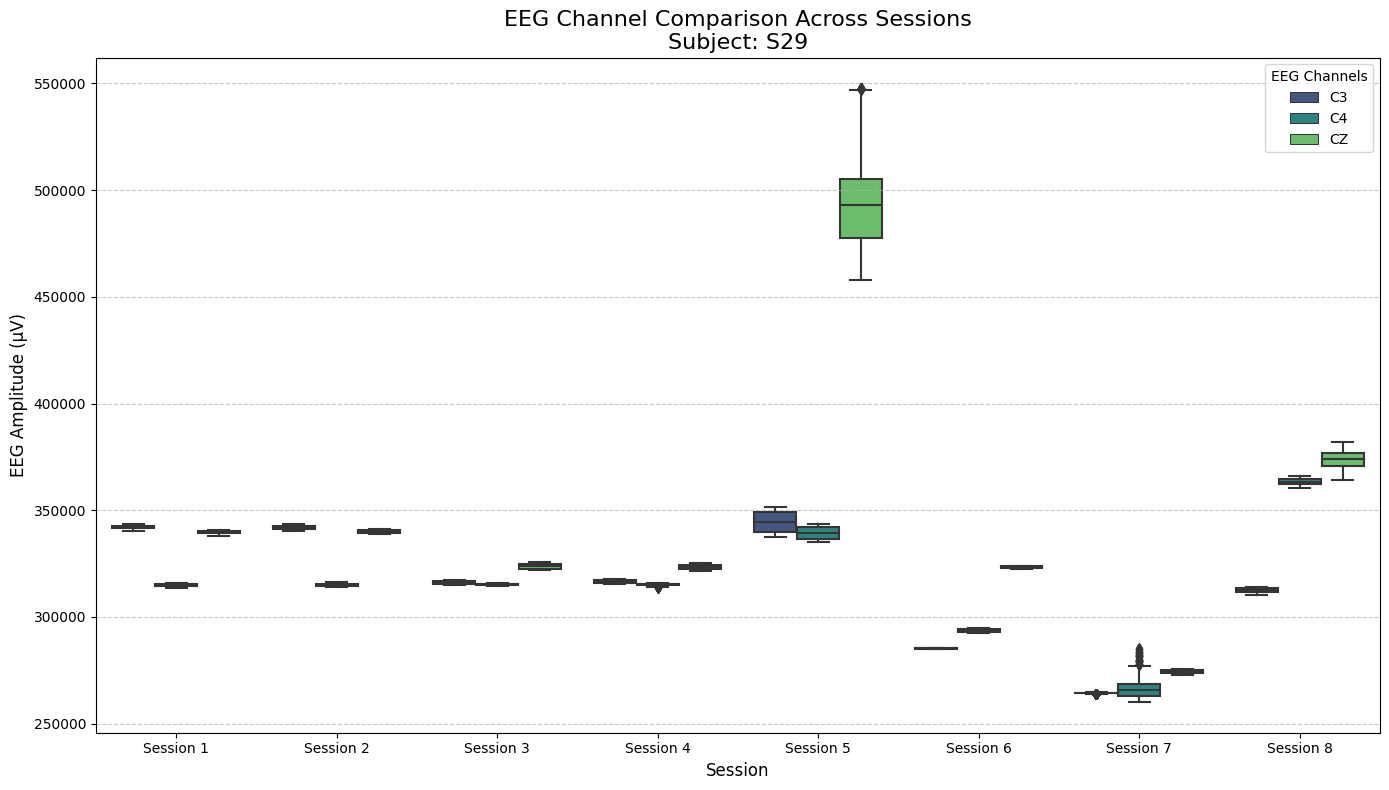

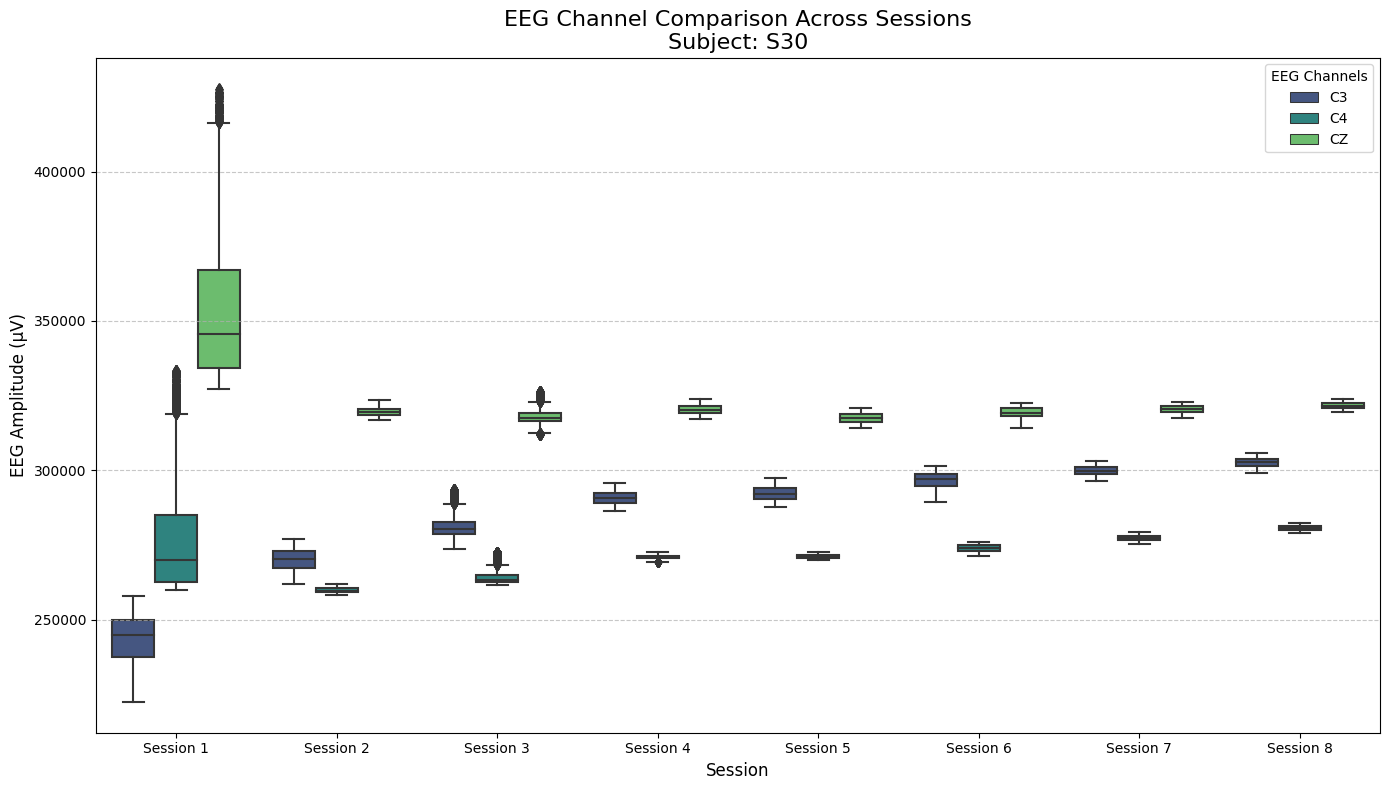

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"

# 1. Function for trial-wise normalization
def normalize_trial(trial_data):
    """
    Apply z-score normalization to EEG channels of a single trial
    Preserves non-EEG columns unchanged
    """
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    normalized_data = trial_data.copy()
    
    for channel in eeg_channels:
        channel_data = trial_data[channel].values
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        # Avoid division by zero
        if std_val > 1e-8:
            normalized_data[channel] = (channel_data - mean_val) / std_val
        else:
            normalized_data[channel] = channel_data - mean_val
    
    return normalized_data

# 2. Function to plot session comparison box plots
def plot_session_comparison(subject_id, base_path=BASE_PATH, task=TASK):
    """
    Generate box plots comparing EEG channels (C3, C4, CZ) across sessions
    for a specific subject
    """
    # Validate subject format
    if not subject_id.startswith('S'):
        subject_id = 'S' + str(subject_id)
    
    subject_path = os.path.join(base_path, task, "train", subject_id)
    
    if not os.path.exists(subject_path):
        print(f"Error: Subject {subject_id} not found in training data")
        return
    
    # Collect all session data
    session_dirs = sorted([d for d in os.listdir(subject_path) if os.path.isdir(os.path.join(subject_path, d))],
                          key=lambda x: int(x))
    
    if not session_dirs:
        print(f"No sessions found for subject {subject_id}")
        return
    
    all_data = []
    channels = ['C3', 'C4', 'CZ']
    
    # Process each session
    for session in session_dirs:
        session_path = os.path.join(subject_path, session, "EEGdata.csv")
        
        if not os.path.exists(session_path):
            print(f"EEG data missing for session {session}")
            continue
            
        # Load and process session data
        df = pd.read_csv(session_path)
        # Extract relevant channels
        session_data = df[channels].copy()
        session_data['Session'] = f"Session {session}"
        all_data.append(session_data)
    
    if not all_data:
        print("No valid EEG data found")
        return
        
    combined_df = pd.concat(all_data, ignore_index=True)
    melted_df = combined_df.melt(id_vars=['Session'], 
                                value_vars=channels,
                                var_name='Channel', 
                                value_name='Amplitude')
    
    # Create plot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Session', y='Amplitude', hue='Channel', data=melted_df, palette="viridis")
    plt.title(f"EEG Channel Comparison Across Sessions\nSubject: {subject_id}", fontsize=16)
    plt.xlabel("Session", fontsize=12)
    plt.ylabel("EEG Amplitude (μV)", fontsize=12)
    plt.legend(title='EEG Channels', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Normalize a sample trial
    sample_subject = "S1"
    sample_session = "1"
    sample_path = os.path.join(BASE_PATH, TASK, "train", sample_subject, sample_session, "EEGdata.csv")
    
    if os.path.exists(sample_path):
        # Load first trial (MI: 2250 samples)
        full_data = pd.read_csv(sample_path)
        trial_data = full_data.iloc[:2250]  # First MI trial
        normalized_trial = normalize_trial(trial_data)
        print("Trial normalization completed.")
        print("Original mean (C3):", trial_data['C3'].mean())
        print("Normalized mean (C3):", normalized_trial['C3'].mean())
        print("Normalized std (C3):", normalized_trial['C3'].std())
    else:
        print("Sample data not available for demonstration")
    
    # Generate session comparison plot
    for i in range(1, 31):
        plot_session_comparison(f"S{i}")